In [5]:
from pathlib import Path
import sys

ROOT = Path.cwd()
while not (ROOT / "src").exists() and ROOT.parent != ROOT:
    ROOT = ROOT.parent

sys.path.insert(0, str(ROOT))

print("Project ROOT:", ROOT)

Project ROOT: C:\Users\fabio\Projetos DEV\Hackathon ONE\churninsight-hackathon-one


## 1 - Ingestão e diagnóstico inicial

In [6]:
from src.data.load_data import list_raw_files
list_raw_files()

,filename,extension,size_bytes,size_human
0,Bank Customer Churn Prediction.csv,csv,561600,548.44 KB
1,WA_Fn-UseC_-Telco-Customer-Churn.csv,csv,977501,954.59 KB


In [7]:
from src.data.load_data import load_and_report_raw_data
df = load_and_report_raw_data("Bank Customer Churn Prediction.csv")

## 2 - Qualidade Estrutural & Tipagem

In [8]:
from src.data.quality_typing import run_quality_and_typing_report
df = run_quality_and_typing_report(df)

Métrica,Antes,Depois,Δ
Linhas,10000.0,10000.0,0.0
Colunas,12.0,12.0,0.0
Memória (MB),1.8,1.8,0.0


## 3 - Conformidade ao Contrato (API) & Preparação Semântica dos Dados

In [9]:
from src.data.contract_loader import load_contract_yaml
from src.features.contract_and_candidates import run_contract_and_candidates
from src.reporting.ui import render_contract_and_candidates_report

CONTRACT_PATH = "contracts/bank_churn.yaml"

cfg = load_contract_yaml(CONTRACT_PATH)
scope = cfg.to_scope()

payload_s31 = run_contract_and_candidates(df, scope=scope)
render_contract_and_candidates_report(payload_s31)
df = payload_s31["df"]

Métrica,Antes,Depois,Δ
Linhas,10000,10000,+0.00
Colunas,12,7,-5.00
Memória,1.80 MB,0.53 MB,-1.27 MB


column,dtype,n_unique,pct_unique,sample_values,reasons
active_member,int64,2,0.0002,"[1, 0]","numérico baixa cardinalidade, binário (yes/no)"
credit_card,int64,2,0.0002,"[1, 0]","numérico baixa cardinalidade, binário (yes/no)"
products_number,int64,4,0.0004,"[1, 3, 2, 4]",numérico baixa cardinalidade
tenure,int64,11,0.0011,"[2, 1, 8, 7, 4, 6]",numérico baixa cardinalidade
column,dtype,n_unique,pct_unique,sample_values,reasons
active_member,int64,2,0.0002,"[1, 0]","numérico baixa cardinalidade, binário (yes/no)"
credit_card,int64,2,0.0002,"[1, 0]","numérico baixa cardinalidade, binário (yes/no)"


> Esta próxima etapa executa a padronização categórica declarada explicitamente, derivada do diagnóstico da Seção 3.
> As transformações são irreversíveis no pipeline, restritas às features do contrato e sem aplicação de encoding.

In [10]:
from src.features.categorical_standardization import run_categorical_standardization
from src.reporting.ui import render_categorical_standardization_report

# Sem regras categóricas para este dataset
S3_CAT_STD_MAP = {}
S3_CAT_STD_COLS = []

payload_s32 = run_categorical_standardization(
    df=df,    
    scope=scope,
    phrase_map=S3_CAT_STD_MAP,
    cols_scope=S3_CAT_STD_COLS,
)

render_categorical_standardization_report(payload_s32)
df = payload_s32["df"]


Métrica,Antes,Depois,Δ
Linhas,10000.0,10000.0,0.0
Colunas,7.0,7.0,0.0
Memória (MB),0.53,0.53,0.0


> Esta próxima etapa realiza uma auditoria **somente diagnóstica** da coluna target, verificando
> presença, domínio e consistência básica dos valores, **sem aplicar qualquer transformação**.
> O objetivo é validar se o target está adequado para a etapa de modelagem.

In [11]:
from src.features.target_audit import run_target_audit
from src.reporting.ui import render_target_audit_report

# domínio esperado do Telco churn
EXPECTED_TARGET = [0, 1]

payload_s33 = run_target_audit(
    df=df,
    scope=scope,
    expected_values=EXPECTED_TARGET
)

render_target_audit_report(payload_s33)

value,count,pct
0,7963,79.63
1,2037,20.37


## 4 - Tratamento de Dados Faltantes

In [12]:
from src.features.missing_imputation import run_missing_imputation
from src.reporting.ui import render_missing_imputation_report

# decision: decisão explícita (SEM defaults escondidos)
decision_s4 = {
    # se None: assume intenção = todas as features (ainda filtradas pelo scope)
    "include_cols": None,
    # opcional: colunas explicitamente excluídas
    "exclude_cols": [],
    # obrigatório
    "numeric_strategy": "median",            # "median" | "mean" | "constant"
    "categorical_strategy": "most_frequent", # "most_frequent" | "constant"
}

payload_s4 = run_missing_imputation(df=df, scope=scope, decision=decision_s4)
df = payload_s4["df"]  
render_missing_imputation_report(payload_s4)

Métrica,Antes,Depois,Δ
Linhas,10000.00,10000.00,0.0
Colunas,7.00,7.00,0.0
Memória (MB),0.53,0.53,0.0
column,kind,strategy,fill_value_used
tenure,numeric,median,5.000
estimated_salary,numeric,median,100193.915
products_number,numeric,median,1.000
credit_score,numeric,median,652.000
active_member,numeric,median,1.000
credit_card,numeric,median,1.000


## 5 - Preparação para Modelagem

In [13]:
from src.features.contract_and_candidates import NormalizationScope
from src.features.train_test_split_prep import run_train_test_split
from src.reporting.ui import render_modeling_report

decision_s5 = {
    "test_size": 0.2,
    "random_state": 42,
    "shuffle": True,
    "stratify": False,
    # "stratify_col": "Churn",  # só se stratify=True
    "audit_categorical_cardinality": False,  
}

payload_s5 = run_train_test_split(
    df=df,
    scope=scope,
    decision=decision_s5,
)

render_modeling_report(payload_s5)

churn,count_all,rate_all,count_train,rate_train,count_test,rate_test,delta_rate_train_vs_all,delta_rate_test_vs_all
0,7963,0.7963,6356,0.7945,1607,0.8035,-0.0018,0.0072
1,2037,0.2037,1644,0.2055,393,0.1965,0.0018,-0.0072


## 6 - Representação para Modelagem Supervisionada

In [14]:
from src.features.supervised_representation import run_supervised_representation
from src.reporting.ui import render_supervised_representation_report

# Inputs canônicos 
split_s5 = payload_s5["split"]     # contém: X_train, X_test, y_train, y_test
scope_s5 = payload_s5["scope"]

# Decisão explícita de representação (NADA é inferido)
decision_s6 = {
    "X": {
        "categorical": {
            "strategy": "onehot",
            "handle_unknown": "ignore",
        },
        "numeric": {
            "strategy": "passthrough",
        },
    },
    "y": {
        "strategy": "map_binary",
        "mapping": {0: 0, 1: 1},  # Bank churn já é binário numérico
        "dtype": "int64",
    },
}

payload_s6 = run_supervised_representation(
    split=split_s5,
    scope=scope_s5,
    decision=decision_s6,
)

render_supervised_representation_report(payload_s6)


raw,encoded
0,0
1,1


## 7 - Estratégia de Avaliação e Baselines

In [15]:
from src.models.evaluation_baselines import run_section7_evaluation_and_baselines
from src.reporting.ui import render_evaluation_report

# ------------------------------------------------------------
# Decisão explícita 
# ------------------------------------------------------------
decision_s7 = {
    "positive_label": 1,                 # churn = 1
    "primary_metric": "recall",           # métrica principal
    "secondary_metrics": ["f1"],          # métrica de apoio
    "baselines": [
        {"name": "most_frequent", "strategy": "most_frequent"},
        {"name": "stratified", "strategy": "stratified"},
    ],
    "average": "binary",                  # escopo restrito da S7
    "zero_division": 0,                   # decisão explícita
    "random_state": 42,                   # reprodutibilidade
}


# ------------------------------------------------------------
# Execução
# ------------------------------------------------------------
payload_s7 = run_section7_evaluation_and_baselines(
    s6_payload=payload_s6,    # saída auditada da Seção 6
    decision=decision_s7,
)

# ------------------------------------------------------------
# Renderização / Auditoria (UI)
# ------------------------------------------------------------
render_evaluation_report(payload_s7)


## 8 - Painel de Modelos & Hiperparâmetros

In [16]:
from src.reporting.models_control_panel import render_section8_models_panel

render_section8_models_panel(payload_s6=payload_s6, payload_s7=payload_s7, payload_s5=payload_s5)


### ✅ Decisão da escolha do modelo (pós-processamento)

Com base nos experimentos realizados nesta seção, a decisão do modelo considera o **critério de avaliação definido na Seção 7** (Estratégia de Avaliação e Baselines) e os **trade-offs observados no Leaderboard**.

A **Decision Tree** apresentou o **maior recall**, alinhando-se diretamente ao critério de risco do problema de churn, cujo objetivo é **maximizar a detecção de clientes propensos a sair**, mesmo ao custo de mais falsos positivos.  
Por outro lado, o **Random Forest** obteve o **melhor F1-score** e o maior **ROC-AUC**, representando a opção com **melhor equilíbrio geral** entre precisão e recall, além de maior capacidade discriminativa.

> **Síntese inicial:**  
> - **Escolha orientada por risco (S7 — recall):** *Decision Tree*  
> - **Escolha orientada por desempenho equilibrado (S8 — F1):** *Random Forest*

Apesar da Decision Tree estar mais diretamente alinhada ao critério de risco definido na Seção 7, a escolha do modelo a ser **exportado** considera também aspectos de **robustez, estabilidade estatística e generalização**.

O **Random Forest** foi selecionado para exportação porque:
- apresentou o **melhor F1-score**, indicando maior equilíbrio entre *recall* e *precision*;
- obteve o maior **ROC-AUC**, demonstrando **melhor capacidade de separação** entre clientes churn e não churn;
- reduz significativamente o risco de **overfitting**, comum em árvores de decisão individuais;
- oferece maior **estabilidade**, sendo menos sensível a variações do conjunto de treino.

Do ponto de vista operacional, essa escolha **não invalida o critério de risco estabelecido na Seção 7**.  
Ao contrário, ela preserva a possibilidade de **ajuste posterior do limiar de decisão (threshold)**, permitindo elevar o *recall* conforme a necessidade do negócio, sem comprometer a capacidade de generalização do modelo.

> 📌 **Síntese final da decisão:**  
> - A **Seção 7** define **qual tipo de erro é inaceitável** (governança de risco).  
> - A **Seção 8** seleciona o modelo com **maior capacidade discriminativa global** para atender a esse critério de forma robusta.  
> - O **Random Forest** representa o melhor ponto de partida para **uso operacional e eventual calibração**.

---

📐 **Nota metodológica sobre os grids de hiperparâmetros**

Os resultados apresentados nesta seção foram obtidos a partir de **grids de hiperparâmetros deliberadamente controlados**, projetados para garantir:
- comparabilidade justa entre modelos,
- custo computacional previsível,
- e reprodutibilidade dos experimentos.

A definição e a fundamentação acadêmica desses grids estão documentadas no arquivo  
**`hyperparameter_grids.md`**, que serve como **referência oficial do projeto** para decisões relacionadas à busca de hiperparâmetros.

Essa escolha metodológica assegura que a decisão do modelo não seja resultado de *tuning excessivo*,  
mas da **capacidade discriminativa intrínseca** dos algoritmos avaliados.


C:\Users\fabio\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[OK] Salvo: C:\Users\fabio\Projetos DEV\Hackathon ONE\churninsight-hackathon-one\notebooks\individual\Fábio Aguiar\images\confusion_matrix_modelo_final.png


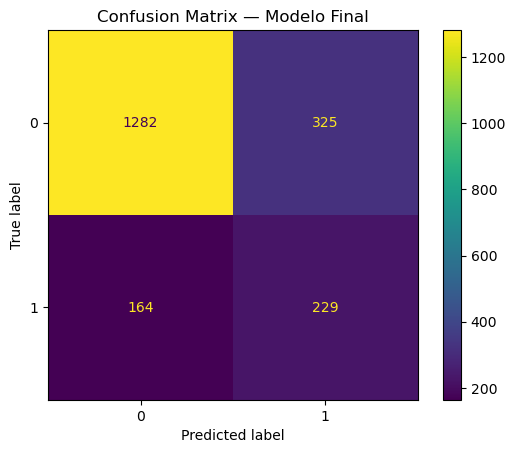

[OK] Salvo: C:\Users\fabio\Projetos DEV\Hackathon ONE\churninsight-hackathon-one\notebooks\individual\Fábio Aguiar\images\roc_curve_modelo_final.png


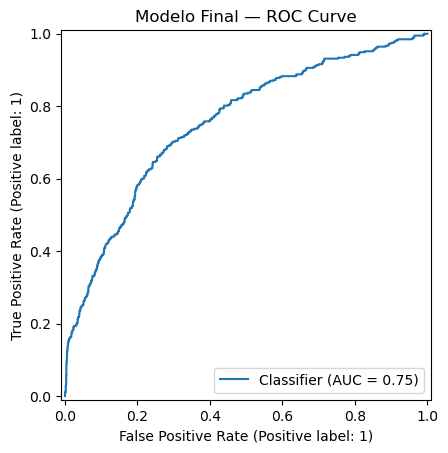

[OK] Salvo: C:\Users\fabio\Projetos DEV\Hackathon ONE\churninsight-hackathon-one\notebooks\individual\Fábio Aguiar\images\precision_recall_curve_modelo_final.png


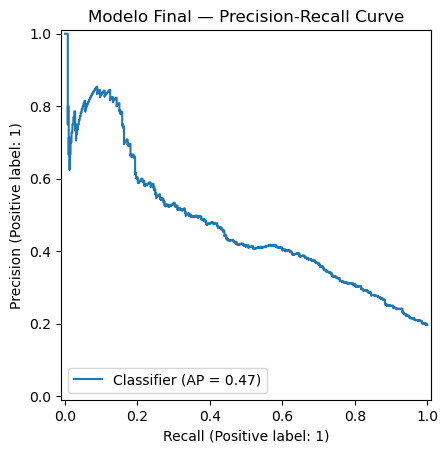

In [23]:
# ============================================================
# Exportação garantida de gráficos (Confusion, ROC, PR)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
)

# --- garante a pasta de imagens
IMAGES_DIR = ROOT / "notebooks" / "individual" / "Fábio Aguiar" / "images"
IMAGES_DIR.mkdir(parents=True, exist_ok=True)

# --- probabilidades (classe positiva = 1)
proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = (proba >= 0.5).astype(int)

# 1) Confusion Matrix
fig, ax = plt.subplots()
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)
ax.set_title("Confusion Matrix — Modelo Final")
out_path = IMAGES_DIR / "confusion_matrix_modelo_final.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print("[OK] Salvo:", out_path)
plt.show()

# 2) ROC Curve
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, proba, ax=ax)
ax.set_title("Modelo Final — ROC Curve")
out_path = IMAGES_DIR / "roc_curve_modelo_final.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print("[OK] Salvo:", out_path)
plt.show()

# 3) Precision-Recall Curve
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, proba, ax=ax)
ax.set_title("Modelo Final — Precision-Recall Curve")
out_path = IMAGES_DIR / "precision_recall_curve_modelo_final.png"
fig.savefig(out_path, dpi=150, bbox_inches="tight")
print("[OK] Salvo:", out_path)
plt.show()
